<a href="https://colab.research.google.com/github/nemoiitkgp/FWI-Codes-PhD/blob/main/Anticline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip -q install deepwave scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 MB 18.9 MB/s eta 0:00:00


Device: cuda
Generating data for 8.00s (Memory Safe)...
Starting Inversion (Fixing Flank Illumination)...
Epoch 010 | Norm Loss: 0.6235 | LR: 35.0000
Epoch 020 | Norm Loss: 0.2103 | LR: 35.0000
Epoch 030 | Norm Loss: 0.1172 | LR: 35.0000
Epoch 040 | Norm Loss: 0.0758 | LR: 35.0000
Epoch 050 | Norm Loss: 0.0562 | LR: 35.0000


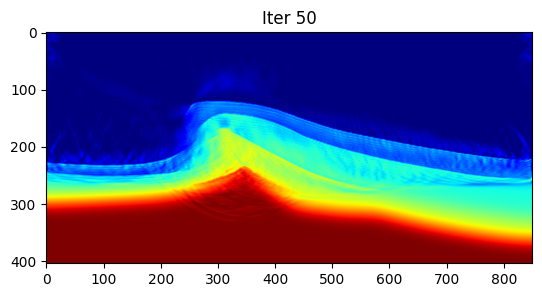

Epoch 060 | Norm Loss: 0.0456 | LR: 35.0000
Epoch 070 | Norm Loss: 0.0400 | LR: 35.0000
Epoch 080 | Norm Loss: 0.0370 | LR: 35.0000
Epoch 090 | Norm Loss: 0.0353 | LR: 35.0000
Epoch 100 | Norm Loss: 0.0344 | LR: 35.0000


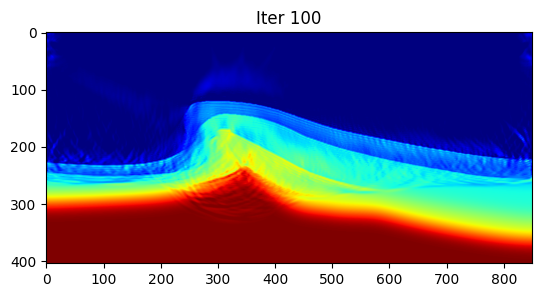

Epoch 110 | Norm Loss: 0.0338 | LR: 35.0000
Epoch 120 | Norm Loss: 0.0335 | LR: 35.0000
Epoch 130 | Norm Loss: 0.0333 | LR: 35.0000
Epoch 140 | Norm Loss: 0.0333 | LR: 35.0000
Epoch 150 | Norm Loss: 0.0333 | LR: 35.0000


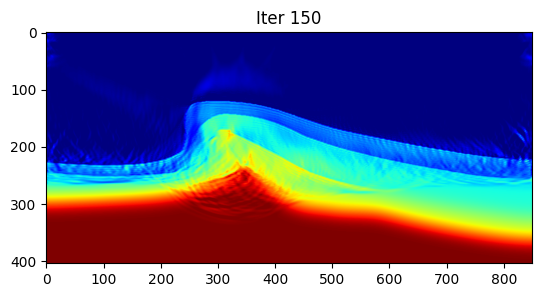

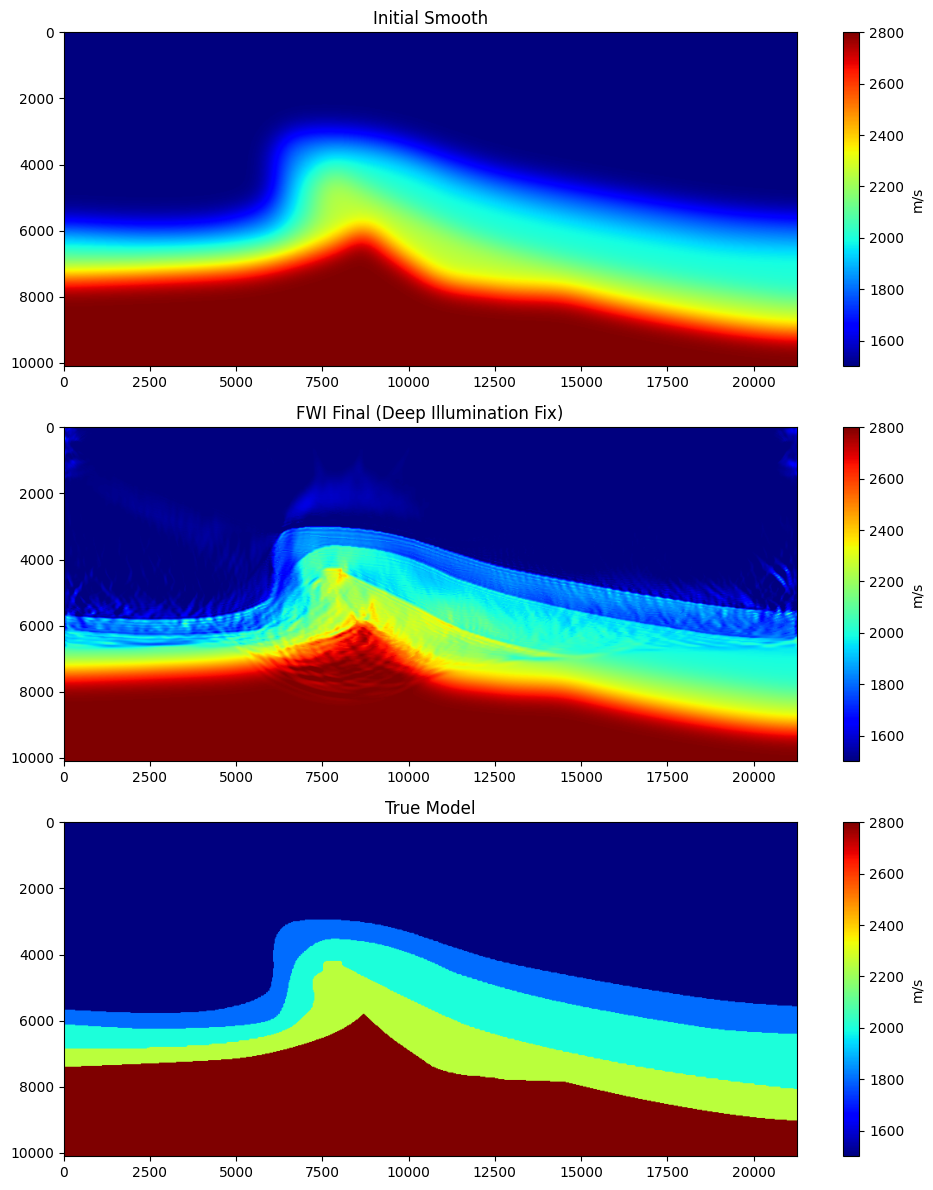

In [ ]:
import numpy as np
import torch
import scipy.io
import gc
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# 0. INITIAL MEMORY CLEAN (Crucial for Colab)
gc.collect()
torch.cuda.empty_cache()

# 1. SETTINGS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 2. INPUT: ANTICLINE MODEL
mat_path = 'anticline_model.mat'
try:
    mat = scipy.io.loadmat(mat_path)
    v_true_np = None
    for key in mat:
        if isinstance(mat[key], np.ndarray):
            arr = np.squeeze(mat[key])
            if arr.ndim == 2:
                v_true_np = arr.astype(np.float32)
                break
    if v_true_np is None: raise ValueError("Invalid 2D array.")
    if np.max(v_true_np) < 10: v_true_np *= 1000.0
except:
    v_true_np = 2000 * np.ones((850, 404), dtype=np.float32)
    v_true_np[:, 200:] = 3500

v_true = torch.from_numpy(v_true_np).to(device)
if v_true.shape[0] < v_true.shape[1]: v_true = v_true.T
nx, nz = v_true.shape

# 3. INITIAL MODEL
v_init_np = 1/gaussian_filter(1/v_true.cpu().numpy(), sigma=15)
v_init = torch.from_numpy(v_init_np).to(device)
v1 = v_init.clone().requires_grad_(True)
vmin, vmax = v_true.min().item(), v_true.max().item()

# 4. GEOMETRY (Optimized for Memory)
pml_v = 20
dx, dz = 25.0, 25.0
spacing = (dx, dz)
dt = 0.004  # Increased from 0.003 to 0.004 to save 25% GPU RAM
nt = 2000   # 2000 * 0.004 = 8.0 Seconds.
freq = 5.0
n_shots = 16

rx = torch.arange(pml_v, nx - pml_v, device=device)
n_receivers_per_shot = len(rx)

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[..., 1] = pml_v + 2
source_loc[:, 0, 0] = torch.linspace(pml_v, nx - pml_v, n_shots).to(torch.long)

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = pml_v + 2
for i in range(n_shots): receiver_loc[i, :, 0] = rx

# Keep source wavelet on CPU to save GPU space
source_amp_cpu = deepwave.wavelets.ricker(freq, nt, dt, 1.5/freq).repeat(n_shots, 1, 1)

# 5. GENERATE DATA (Sequential to stay under 15GB)
print(f"Generating data for {nt*dt:.2f}s (Memory Safe)...")
observed_data_cpu = torch.zeros(n_shots, n_receivers_per_shot, nt)

with torch.no_grad():
    for i in range(n_shots):
        s_amp = source_amp_cpu[i:i+1].to(device)
        out = scalar(v_true, spacing, dt, source_amplitudes=s_amp,
                     source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                     pml_width=[pml_v]*4, pml_freq=freq)
        observed_data_cpu[i] = out[-1].cpu()
        del out, s_amp
        torch.cuda.empty_cache()

# Pre-calculate initial loss for normalization
with torch.no_grad():
    initial_loss = 0
    for i in range(n_shots):
        s_amp = source_amp_cpu[i:i+1].to(device)
        out_init = scalar(v1, spacing, dt, source_amplitudes=s_amp,
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)
        initial_loss += torch.nn.MSELoss()(out_init[-1], observed_data_cpu[i:i+1].to(device)).item()
        del out_init, s_amp
    initial_loss /= n_shots

# 6. ILLUMINATION COMPENSATION (Fix for the deep flanks)
z = torch.linspace(0, 1, nz, device=device)
z_gain = (1.0 + 35.0 * z**3).view(1, nz) # Cubic depth boost
x_gain = torch.ones(nx, device=device) # Edge boost for flanks
x_gain[:150] = torch.linspace(1.8, 1.0, 150, device=device)
x_gain[-150:] = torch.linspace(1.0, 1.8, 150, device=device)
full_gain = z_gain * x_gain.view(nx, 1)

# 7. INVERSION
optimizer = torch.optim.Adam([v1], lr=35.0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=12)
loss_history = []

print("Starting Inversion (Fixing Flank Illumination)...")
for epoch in range(150):
    optimizer.zero_grad()
    epoch_loss = 0

    for i in range(n_shots):
        # Move only current shot to GPU
        curr_source = source_amp_cpu[i:i+1].to(device)
        curr_obs = observed_data_cpu[i:i+1].to(device)

        out_pred = scalar(v1, spacing, dt, source_amplitudes=curr_source,
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)

        loss = torch.nn.MSELoss()(out_pred[-1], curr_obs)
        (loss / (initial_loss * n_shots)).backward()
        epoch_loss += (loss / initial_loss).item()

        # Immediate cleanup of heavy tensors
        del out_pred, curr_source, curr_obs
        torch.cuda.empty_cache()

    epoch_loss /= n_shots

    # Process Gradient
    with torch.no_grad():
        if v1.grad is not None:
            v1.grad *= full_gain # Apply illumination correction
            torch.nn.utils.clip_grad_norm_(v1, max_norm=0.8) # Prevent loss explosion
            grad = gaussian_filter(v1.grad.cpu().numpy(), sigma=2.0)
            v1.grad.copy_(torch.from_numpy(grad).to(device))
            optimizer.step()
            v1.clamp_(min=vmin, max=vmax)

    scheduler.step(epoch_loss)
    loss_history.append(epoch_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:03d} | Norm Loss: {epoch_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.4f}")

    if (epoch + 1) % 50 == 0:
        plt.figure(figsize=(8,3)); plt.imshow(v1.detach().cpu().numpy().T, cmap='jet', vmin=vmin, vmax=vmax); plt.title(f"Iter {epoch+1}"); plt.show()
        gc.collect(); torch.cuda.empty_cache()

# 8. FINAL PLOTS
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
imgs = [v_init.cpu().numpy(), v1.detach().cpu().numpy(), v_true.cpu().numpy()]
titles = ["Initial Smooth", "FWI Final (Deep Illumination Fix)", "True Model"]
for i in range(3):
    im = ax[i].imshow(imgs[i].T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax, extent=[0, nx*dx, nz*dz, 0])
    ax[i].set_title(titles[i]); fig.colorbar(im, ax=ax[i], label='m/s')
plt.tight_layout(); plt.show()

### 300 iterations

Device: cuda
Generating observed data (Sequential)...
Starting Inversion from Highly Smoothed Model (Sigma=40)...
Epoch 010 | Norm Loss: 2.1369 | LR: 35.0000
Epoch 020 | Norm Loss: 0.5909 | LR: 17.5000
Epoch 030 | Norm Loss: 0.3447 | LR: 17.5000
Epoch 040 | Norm Loss: 0.2294 | LR: 17.5000
Epoch 050 | Norm Loss: 0.1607 | LR: 17.5000


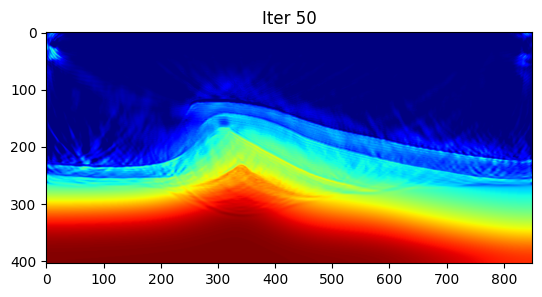

Epoch 060 | Norm Loss: 0.1140 | LR: 17.5000
Epoch 070 | Norm Loss: 0.0819 | LR: 17.5000
Epoch 080 | Norm Loss: 0.0600 | LR: 17.5000
Epoch 090 | Norm Loss: 0.0447 | LR: 17.5000
Epoch 100 | Norm Loss: 0.0344 | LR: 17.5000


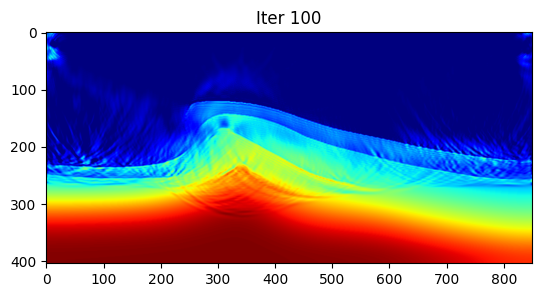

Epoch 110 | Norm Loss: 0.0276 | LR: 17.5000
Epoch 120 | Norm Loss: 0.0230 | LR: 17.5000
Epoch 130 | Norm Loss: 0.0197 | LR: 17.5000
Epoch 140 | Norm Loss: 0.0171 | LR: 17.5000
Epoch 150 | Norm Loss: 0.0150 | LR: 17.5000


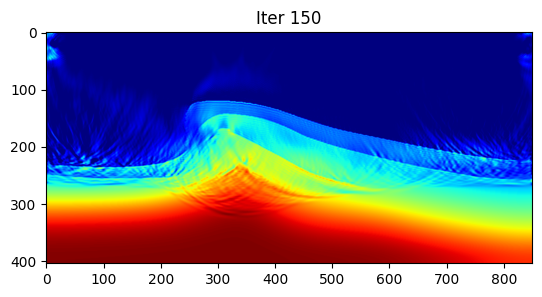

Epoch 160 | Norm Loss: 0.0134 | LR: 17.5000
Epoch 170 | Norm Loss: 0.0118 | LR: 17.5000
Epoch 180 | Norm Loss: 0.0105 | LR: 17.5000
Epoch 190 | Norm Loss: 0.0096 | LR: 17.5000
Epoch 200 | Norm Loss: 0.0087 | LR: 17.5000


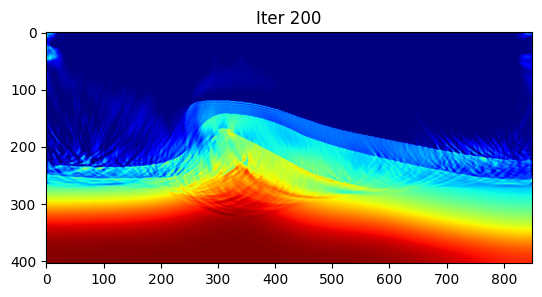

Epoch 210 | Norm Loss: 0.0078 | LR: 17.5000
Epoch 220 | Norm Loss: 0.0071 | LR: 17.5000
Epoch 230 | Norm Loss: 0.0065 | LR: 17.5000
Epoch 240 | Norm Loss: 0.0059 | LR: 17.5000
Epoch 250 | Norm Loss: 0.0054 | LR: 17.5000


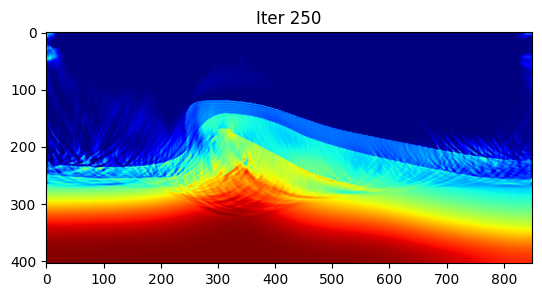

Epoch 260 | Norm Loss: 0.0049 | LR: 17.5000
Epoch 270 | Norm Loss: 0.0045 | LR: 17.5000
Epoch 280 | Norm Loss: 0.0041 | LR: 17.5000
Epoch 290 | Norm Loss: 0.0039 | LR: 17.5000
Epoch 300 | Norm Loss: 0.0035 | LR: 17.5000


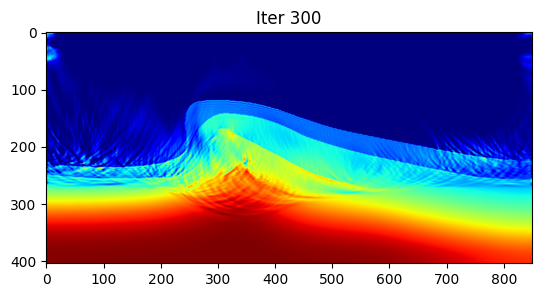

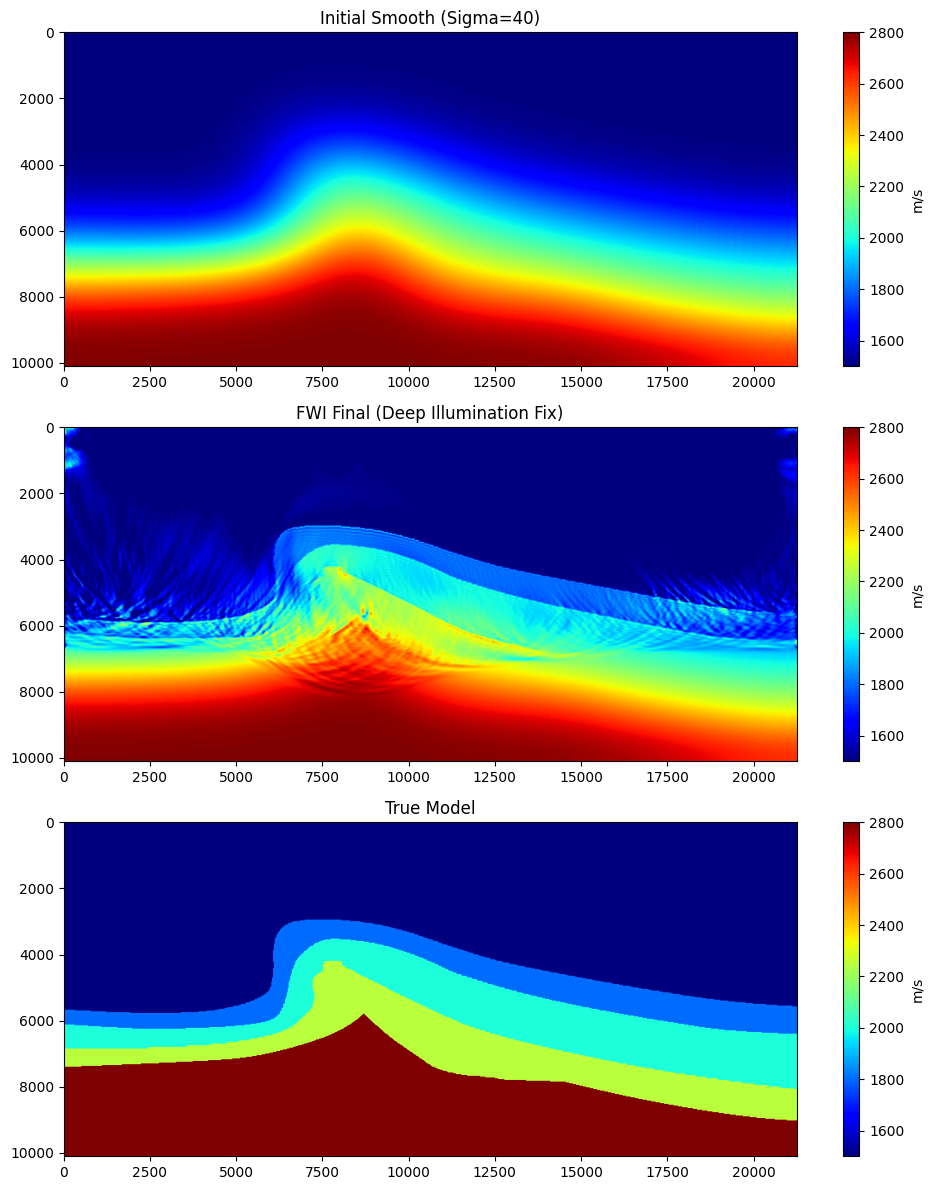

In [ ]:
import numpy as np
import torch
import scipy.io
import gc
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# 0. INITIAL MEMORY CLEAN
gc.collect()
torch.cuda.empty_cache()

# 1. SETTINGS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 2. INPUT: ANTICLINE MODEL
mat_path = 'anticline_model.mat'
try:
    mat = scipy.io.loadmat(mat_path)
    v_true_np = None
    for key in mat:
        if isinstance(mat[key], np.ndarray):
            arr = np.squeeze(mat[key])
            if arr.ndim == 2:
                v_true_np = arr.astype(np.float32)
                break
    if v_true_np is None: raise ValueError("Invalid 2D array.")
    if np.max(v_true_np) < 10: v_true_np *= 1000.0
except:
    # Fallback if file not found
    v_true_np = 2000 * np.ones((850, 404), dtype=np.float32)
    v_true_np[:, 200:] = 3500

v_true = torch.from_numpy(v_true_np).to(device)
if v_true.shape[0] < v_true.shape[1]: v_true = v_true.T
nx, nz = v_true.shape

# 3. INITIAL MODEL (INCREASED SMOOTHING AS REQUESTED)
# sigma increased from 15 to 40 to make it much blurrier
v_init_np = 1/gaussian_filter(1/v_true.cpu().numpy(), sigma=40)
v_init = torch.from_numpy(v_init_np).to(device)
v1 = v_init.clone().requires_grad_(True)
vmin, vmax = v_true.min().item(), v_true.max().item()

# 4. GEOMETRY (Optimized for T4 15GB RAM)
pml_v = 20
dx, dz = 25.0, 25.0
spacing = (dx, dz)
dt = 0.004  # 0.004 helps memory compared to 0.003
nt = 2000   # 8 seconds total
freq = 5.0
n_shots = 16

rx = torch.arange(pml_v, nx - pml_v, device=device)
n_receivers_per_shot = len(rx)

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[..., 1] = pml_v + 2
source_loc[:, 0, 0] = torch.linspace(pml_v, nx - pml_v, n_shots).to(torch.long)

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = pml_v + 2
for i in range(n_shots): receiver_loc[i, :, 0] = rx

source_amp_cpu = deepwave.wavelets.ricker(freq, nt, dt, 1.5/freq).repeat(n_shots, 1, 1)

# 5. GENERATE OBSERVED DATA
print("Generating observed data (Sequential)...")
observed_data_cpu = torch.zeros(n_shots, n_receivers_per_shot, nt)
with torch.no_grad():
    for i in range(n_shots):
        s_amp = source_amp_cpu[i:i+1].to(device)
        out = scalar(v_true, spacing, dt, source_amplitudes=s_amp,
                     source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                     pml_width=[pml_v]*4, pml_freq=freq)
        observed_data_cpu[i] = out[-1].cpu()
        del out, s_amp
        torch.cuda.empty_cache()

# Initial Loss for Normalization
with torch.no_grad():
    initial_loss = 0
    for i in range(n_shots):
        s_amp = source_amp_cpu[i:i+1].to(device)
        out_init = scalar(v1, spacing, dt, source_amplitudes=s_amp,
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)
        initial_loss += torch.nn.MSELoss()(out_init[-1], observed_data_cpu[i:i+1].to(device)).item()
        del out_init, s_amp
    initial_loss /= n_shots

# 6. ILLUMINATION & DEPTH GAIN
z = torch.linspace(0, 1, nz, device=device)
z_gain = (1.0 + 35.0 * z**3).view(1, nz) # Stronger depth reach
x_gain = torch.ones(nx, device=device)
x_gain[:150] = torch.linspace(1.8, 1.0, 150, device=device) # Flank boost
x_gain[-150:] = torch.linspace(1.0, 1.8, 150, device=device) # Flank boost
full_gain = z_gain * x_gain.view(nx, 1)

# 7. INVERSION
optimizer = torch.optim.Adam([v1], lr=35.0)
# Scheduler cuts LR to prevent loss increase after 100 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
loss_history = []

print(f"Starting Inversion from Highly Smoothed Model (Sigma=40)...")
for epoch in range(300):
    optimizer.zero_grad()
    epoch_loss = 0

    for i in range(n_shots):
        curr_source = source_amp_cpu[i:i+1].to(device)
        curr_obs = observed_data_cpu[i:i+1].to(device)

        out_pred = scalar(v1, spacing, dt, source_amplitudes=curr_source,
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)

        loss = torch.nn.MSELoss()(out_pred[-1], curr_obs)
        (loss / (initial_loss * n_shots)).backward()
        epoch_loss += (loss / initial_loss).item()

        del out_pred, curr_source, curr_obs
        torch.cuda.empty_cache()

    epoch_loss /= n_shots

    # Process Gradient
    with torch.no_grad():
        if v1.grad is not None:
            v1.grad *= full_gain
            # Clamp gradients to maintain stability
            torch.nn.utils.clip_grad_norm_(v1, max_norm=0.8)

            # Smoothing gradient: Reduce smoothing as we progress to get sharper details
            current_sigma = max(2.5 * (0.99**epoch), 1.2)
            grad = gaussian_filter(v1.grad.cpu().numpy(), sigma=current_sigma)

            v1.grad.copy_(torch.from_numpy(grad).to(device))
            optimizer.step()
            v1.clamp_(min=vmin, max=vmax)

    scheduler.step(epoch_loss)
    loss_history.append(epoch_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:03d} | Norm Loss: {epoch_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.4f}")

    if (epoch + 1) % 50 == 0:
        plt.figure(figsize=(8,3)); plt.imshow(v1.detach().cpu().numpy().T, cmap='jet', vmin=vmin, vmax=vmax); plt.title(f"Iter {epoch+1}"); plt.show()
        gc.collect(); torch.cuda.empty_cache()

# 8. FINAL PLOTS
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
imgs = [v_init.cpu().numpy(), v1.detach().cpu().numpy(), v_true.cpu().numpy()]
titles = [f"Initial Smooth (Sigma=40)", "FWI Final (Deep Illumination Fix)", "True Model"]
for i in range(3):
    im = ax[i].imshow(imgs[i].T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax, extent=[0, nx*dx, nz*dz, 0])
    ax[i].set_title(titles[i]); fig.colorbar(im, ax=ax[i], label='m/s')
plt.tight_layout(); plt.show()

In [3]:
import numpy as np
import torch
import scipy.io
import gc
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# 0. INITIAL MEMORY CLEAN
gc.collect()
torch.cuda.empty_cache()

# 1. SETTINGS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 2. INPUT: ANTICLINE MODEL
mat_path = 'anticline_model.mat'
try:
    mat = scipy.io.loadmat(mat_path)
    v_true_np = None
    for key in mat:
        if isinstance(mat[key], np.ndarray):
            arr = np.squeeze(mat[key])
            if arr.ndim == 2:
                v_true_np = arr.astype(np.float32)
                break
    if v_true_np is None: raise ValueError("Invalid 2D array.")
    if np.max(v_true_np) < 10: v_true_np *= 1000.0
except:
    v_true_np = 2000 * np.ones((850, 404), dtype=np.float32)
    v_true_np[:, 200:] = 3500

v_true = torch.from_numpy(v_true_np).to(device)
if v_true.shape[0] < v_true.shape[1]: v_true = v_true.T
nx, nz = v_true.shape

# 3. INITIAL MODEL
v_init_np = 1/gaussian_filter(1/v_true.cpu().numpy(), sigma=40)
v_init = torch.from_numpy(v_init_np).to(device)
v1 = v_init.clone().requires_grad_(True)
vmin, vmax = v_true.min().item(), v_true.max().item()

# 4. GEOMETRY (Adjusted for Deep Illumination)
pml_v = 20
dx, dz = 25.0, 25.0
spacing = (dx, dz)
dt = 0.004
nt = 3000   # INCREASED to 12s to allow deep waves to return to surface
freq = 4.5  # Slightly lower frequency helps deeper penetration
n_shots = 24 # INCREASED shot density for better flank coverage

rx = torch.arange(pml_v, nx - pml_v, device=device)
n_receivers_per_shot = len(rx)

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[..., 1] = pml_v + 2
source_loc[:, 0, 0] = torch.linspace(pml_v, nx - pml_v, n_shots).to(torch.long)

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = pml_v + 2
for i in range(n_shots): receiver_loc[i, :, 0] = rx

source_amp_cpu = deepwave.wavelets.ricker(freq, nt, dt, 1.5/freq).repeat(n_shots, 1, 1)

# 5. GENERATE OBSERVED DATA
print(f"Generating observed data ({nt} steps, {n_shots} shots)...")
observed_data_cpu = torch.zeros(n_shots, n_receivers_per_shot, nt)
with torch.no_grad():
    for i in range(n_shots):
        s_amp = source_amp_cpu[i:i+1].to(device)
        out = scalar(v_true, spacing, dt, source_amplitudes=s_amp,
                     source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                     pml_width=[pml_v]*4, pml_freq=freq)
        observed_data_cpu[i] = out[-1].cpu()
        del out, s_amp
        torch.cuda.empty_cache()

with torch.no_grad():
    initial_loss = 0
    for i in range(n_shots):
        s_amp = source_amp_cpu[i:i+1].to(device)
        out_init = scalar(v1, spacing, dt, source_amplitudes=s_amp,
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)
        initial_loss += torch.nn.MSELoss()(out_init[-1], observed_data_cpu[i:i+1].to(device)).item()
        del out_init, s_amp
    initial_loss /= n_shots

# 6. ENHANCED DEEP ILLUMINATION GAIN
z_coords = torch.linspace(0, 1, nz, device=device)
# Stronger z^4 scaling to compensate for spherical spreading and attenuation
z_gain = (1.0 + 65.0 * z_coords**4).view(1, nz)

x_gain = torch.ones(nx, device=device)
# Wider flank boost to reach the deep corners
flank_width = 200
x_gain[:flank_width] = torch.linspace(2.5, 1.0, flank_width, device=device)
x_gain[-flank_width:] = torch.linspace(1.0, 2.5, flank_width, device=device)
full_gain = z_gain * x_gain.view(nx, 1)

# 7. INVERSION
optimizer = torch.optim.Adam([v1], lr=30.0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=12)
loss_history = []

print(f"Starting Inversion with Deep Illumination Fix...")
for epoch in range(300):
    optimizer.zero_grad()
    epoch_loss = 0

    # Sequential processing to save memory on T4
    for i in range(n_shots):
        curr_source = source_amp_cpu[i:i+1].to(device)
        curr_obs = observed_data_cpu[i:i+1].to(device)

        out_pred = scalar(v1, spacing, dt, source_amplitudes=curr_source,
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)

        loss = torch.nn.MSELoss()(out_pred[-1], curr_obs)
        # Weighting loss by time could be done here, but gradient gain is more stable
        (loss / (initial_loss * n_shots)).backward()
        epoch_loss += (loss / initial_loss).item()

        del out_pred, curr_source, curr_obs
        torch.cuda.empty_cache()

    epoch_loss /= n_shots

    # Process Gradient with Preconditioning
    with torch.no_grad():
        if v1.grad is not None:
            # Apply the illumination fix to the gradient
            v1.grad *= full_gain

            # Slightly higher clip norm to allow deep updates to propagate
            torch.nn.utils.clip_grad_norm_(v1, max_norm=1.0)

            # Gradual sharpening
            current_sigma = max(2.5 * (0.985**epoch), 1.0)
            grad = gaussian_filter(v1.grad.cpu().numpy(), sigma=current_sigma)

            v1.grad.copy_(torch.from_numpy(grad).to(device))
            optimizer.step()
            v1.clamp_(min=vmin, max=vmax)

    scheduler.step(epoch_loss)
    loss_history.append(epoch_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:03d} | Loss: {epoch_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.4f}")

    if (epoch + 1) % 100 == 0:
        gc.collect(); torch.cuda.empty_cache()

# 8. FINAL PLOTS
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
imgs = [v_init.cpu().numpy(), v1.detach().cpu().numpy(), v_true.cpu().numpy()]
titles = ["Initial Smooth Model", "FWI Final (Deep Illumination Fix)", "True Model"]
for i in range(3):
    im = ax[i].imshow(imgs[i].T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax, extent=[0, nx*dx, nz*dz, 0])
    ax[i].set_title(titles[i]); fig.colorbar(im, ax=ax[i], label='m/s')
plt.tight_layout(); plt.show()

Device: cuda
Generating observed data (3000 steps, 24 shots)...
Starting Inversion with Deep Illumination Fix...
Epoch 010 | Loss: 0.7962 | LR: 30.0000


KeyboardInterrupt: 

Device: cuda
Generating data with nt=3000 for deep reach...
Starting Inversion (Progress plots every 50 epochs)...
Epoch 010 | Norm Loss: 0.7968 | LR: 30.0000
Epoch 020 | Norm Loss: 0.4014 | LR: 30.0000
Epoch 030 | Norm Loss: 0.2873 | LR: 30.0000
Epoch 040 | Norm Loss: 0.2324 | LR: 30.0000
Epoch 050 | Norm Loss: 0.1910 | LR: 30.0000


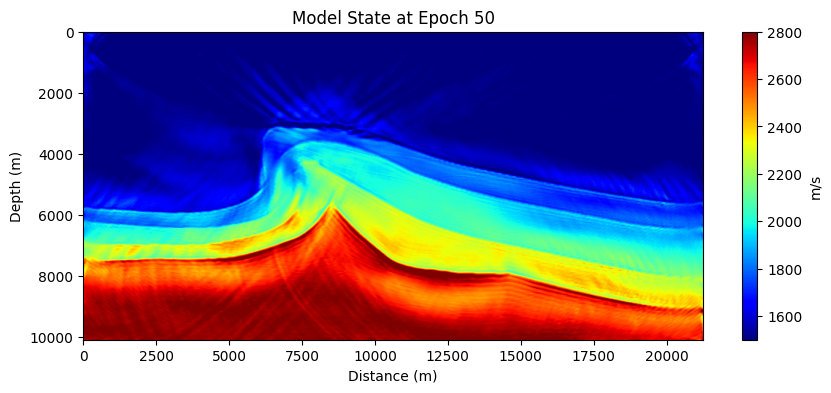

Epoch 060 | Norm Loss: 0.1551 | LR: 30.0000
Epoch 070 | Norm Loss: 0.1156 | LR: 30.0000
Epoch 080 | Norm Loss: 0.0756 | LR: 30.0000
Epoch 090 | Norm Loss: 0.0490 | LR: 30.0000
Epoch 100 | Norm Loss: 0.0336 | LR: 30.0000


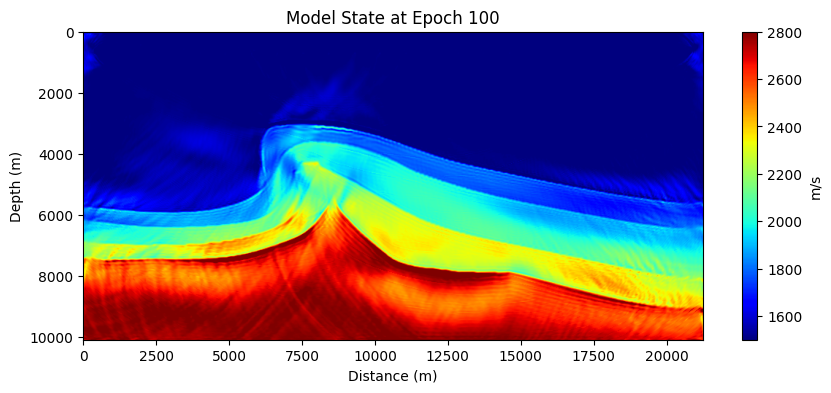

Epoch 110 | Norm Loss: 0.0240 | LR: 30.0000
Epoch 120 | Norm Loss: 0.0173 | LR: 30.0000
Epoch 130 | Norm Loss: 0.0126 | LR: 30.0000
Epoch 140 | Norm Loss: 0.0093 | LR: 30.0000
Epoch 150 | Norm Loss: 0.0070 | LR: 30.0000


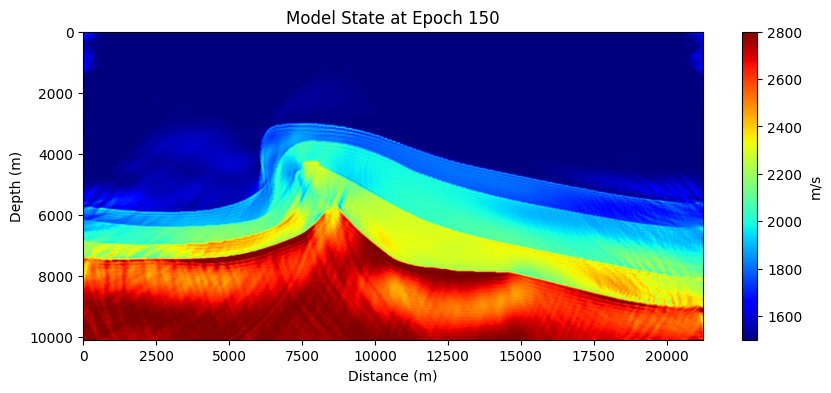

Epoch 160 | Norm Loss: 0.0055 | LR: 30.0000
Epoch 170 | Norm Loss: 0.0042 | LR: 30.0000
Epoch 180 | Norm Loss: 0.0033 | LR: 30.0000
Epoch 190 | Norm Loss: 0.0026 | LR: 30.0000
Epoch 200 | Norm Loss: 0.0025 | LR: 30.0000


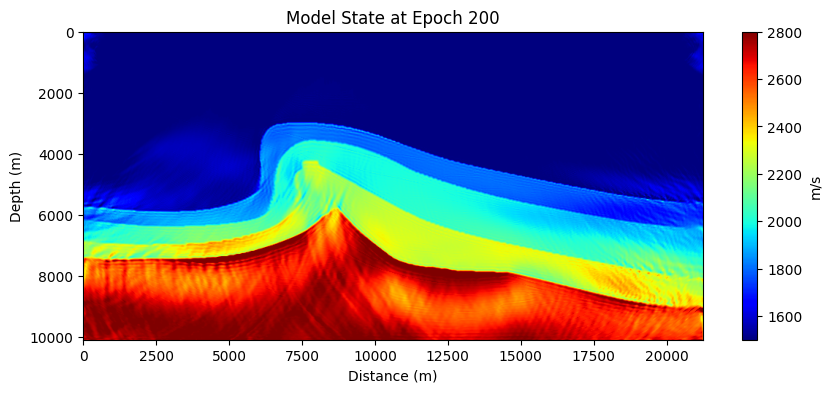

Epoch 210 | Norm Loss: 0.0044 | LR: 30.0000


In [ ]:
import numpy as np
import torch
import scipy.io
import gc
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# 0. INITIAL MEMORY CLEAN
gc.collect()
torch.cuda.empty_cache()

# 1. SETTINGS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 2. INPUT: ANTICLINE MODEL
mat_path = 'anticline_model.mat'
try:
    mat = scipy.io.loadmat(mat_path)
    v_true_np = None
    for key in mat:
        if isinstance(mat[key], np.ndarray):
            arr = np.squeeze(mat[key])
            if arr.ndim == 2:
                v_true_np = arr.astype(np.float32)
                break
    if v_true_np is None: raise ValueError("Invalid 2D array.")
    if np.max(v_true_np) < 10: v_true_np *= 1000.0
except:
    # Fallback synthetic if file is missing
    v_true_np = 2000 * np.ones((850, 404), dtype=np.float32)
    v_true_np[:, 200:] = 3500

v_true = torch.from_numpy(v_true_np).to(device)
if v_true.shape[0] < v_true.shape[1]: v_true = v_true.T
nx, nz = v_true.shape

# 3. INITIAL MODEL (Strongly Smoothed)
v_init_np = 1/gaussian_filter(1/v_true.cpu().numpy(), sigma=40)
v_init = torch.from_numpy(v_init_np).to(device)
v1 = v_init.clone().requires_grad_(True)
vmin, vmax = v_true.min().item(), v_true.max().item()

# 4. GEOMETRY (Optimized for T4 and Deep Illumination)
pml_v = 20
dx, dz = 25.0, 25.0
spacing = (dx, dz)
dt = 0.004
nt = 3000   # 12 seconds: Essential for deep corner reflections to reach surface
freq = 4.5  # Slightly lower frequency penetrates deeper structures better
n_shots = 24 # Increased shots for better corner illumination

rx = torch.arange(pml_v, nx - pml_v, device=device)
n_receivers_per_shot = len(rx)

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[..., 1] = pml_v + 2
source_loc[:, 0, 0] = torch.linspace(pml_v, nx - pml_v, n_shots).to(torch.long)

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = pml_v + 2
for i in range(n_shots): receiver_loc[i, :, 0] = rx

source_amp_cpu = deepwave.wavelets.ricker(freq, nt, dt, 1.5/freq).repeat(n_shots, 1, 1)

# 5. GENERATE OBSERVED DATA
print(f"Generating data with nt={nt} for deep reach...")
observed_data_cpu = torch.zeros(n_shots, n_receivers_per_shot, nt)
with torch.no_grad():
    for i in range(n_shots):
        s_amp = source_amp_cpu[i:i+1].to(device)
        out = scalar(v_true, spacing, dt, source_amplitudes=s_amp,
                     source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                     pml_width=[pml_v]*4, pml_freq=freq)
        observed_data_cpu[i] = out[-1].cpu()
        del out, s_amp
        torch.cuda.empty_cache()

# 6. ENHANCED DEEP ILLUMINATION PRECONDITIONER
z_coords = torch.linspace(0, 1, nz, device=device)
# Aggressive power scaling (z^4) to force updates into the bottom of the model
z_gain = (1.0 + 80.0 * z_coords**4).view(1, nz)

x_gain = torch.ones(nx, device=device)
# Wider flank boost (200 grid points) to reach those corner "dead zones"
flank_w = 200
x_gain[:flank_w] = torch.linspace(2.2, 1.0, flank_w, device=device)
x_gain[-flank_w:] = torch.linspace(1.0, 2.2, flank_w, device=device)
full_gain = z_gain * x_gain.view(nx, 1)

# 7. INVERSION
optimizer = torch.optim.Adam([v1], lr=30.0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)
loss_history = []

# Get initial loss for normalization
with torch.no_grad():
    init_mse = 0
    for i in range(n_shots):
        out_init = scalar(v1, spacing, dt, source_amplitudes=source_amp_cpu[i:i+1].to(device),
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)
        init_mse += torch.nn.MSELoss()(out_init[-1], observed_data_cpu[i:i+1].to(device)).item()
    init_mse /= n_shots

print(f"Starting Inversion (Progress plots every 50 epochs)...")
for epoch in range(300):
    optimizer.zero_grad()
    epoch_loss = 0

    # Sequential loop to prevent OOM on T4 GPU
    for i in range(n_shots):
        curr_source = source_amp_cpu[i:i+1].to(device)
        curr_obs = observed_data_cpu[i:i+1].to(device)

        out_pred = scalar(v1, spacing, dt, source_amplitudes=curr_source,
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)

        loss = torch.nn.MSELoss()(out_pred[-1], curr_obs)
        (loss / (init_mse * n_shots)).backward()
        epoch_loss += (loss / init_mse).item()

        del out_pred, curr_source, curr_obs
        torch.cuda.empty_cache()

    epoch_loss /= n_shots

    # Process Gradient with Illumination Fix
    with torch.no_grad():
        if v1.grad is not None:
            v1.grad *= full_gain
            torch.nn.utils.clip_grad_norm_(v1, max_norm=1.0)

            # Gradually reduce smoothing to resolve finer details over time
            current_sigma = max(2.5 * (0.985**epoch), 1.0)
            grad_np = gaussian_filter(v1.grad.cpu().numpy(), sigma=current_sigma)

            v1.grad.copy_(torch.from_numpy(grad_np).to(device))
            optimizer.step()
            v1.clamp_(min=vmin, max=vmax)

    scheduler.step(epoch_loss)
    loss_history.append(epoch_loss)

    # OUTPUT PROGRESS EVERY 10 EPOCHS
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:03d} | Norm Loss: {epoch_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.4f}")

    # PLOT EVERY 50 EPOCHS AS REQUESTED
    if (epoch + 1) % 50 == 0:
        plt.figure(figsize=(10, 4))
        plt.imshow(v1.detach().cpu().numpy().T, cmap='jet', vmin=vmin, vmax=vmax,
                   extent=[0, nx*dx, nz*dz, 0], aspect='auto')
        plt.title(f"Model State at Epoch {epoch+1}")
        plt.xlabel("Distance (m)"); plt.ylabel("Depth (m)")
        plt.colorbar(label='m/s')
        plt.show()
        gc.collect(); torch.cuda.empty_cache()

# 8. FINAL COMPARISON PLOTS
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
imgs = [v_init.cpu().numpy(), v1.detach().cpu().numpy(), v_true.cpu().numpy()]
titles = ["Initial Model", "FWI Inverted Model", "True Model"]
for i in range(3):
    im = ax[i].imshow(imgs[i].T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax, extent=[0, nx*dx, nz*dz, 0])
    ax[i].set_title(titles[i])
    fig.colorbar(im, ax=ax[i], label='m/s')
plt.tight_layout(); plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Assuming loss_history is the list populated during your training loop
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_history) + 1), loss_history, color='blue', linewidth=2, label='Normalized MSE Loss')
plt.title('FWI Convergence Curve', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Normalized Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Optional: Set Y-axis to log scale if the loss drop is very large
# plt.yscale('log')

plt.tight_layout()
plt.show()

### 600 iterations of the 300 iteration case

Device: cuda
Generating observed data (Sequential)...
Starting Inversion from Highly Smoothed Model (Sigma=40)...
Epoch 010 | Norm Loss: 2.1369 | LR: 35.0000
Epoch 020 | Norm Loss: 0.5909 | LR: 17.5000
Epoch 030 | Norm Loss: 0.3447 | LR: 17.5000
Epoch 040 | Norm Loss: 0.2294 | LR: 17.5000
Epoch 050 | Norm Loss: 0.1607 | LR: 17.5000


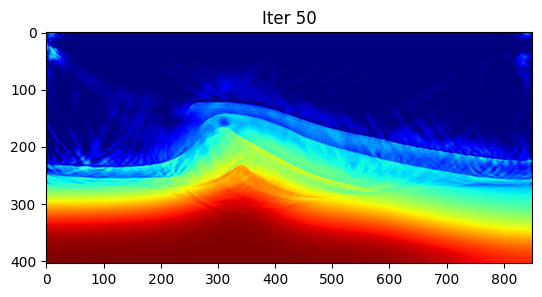

Epoch 060 | Norm Loss: 0.1140 | LR: 17.5000


Device: cuda
Generating synthetic data from True Model...
Starting Inversion from Linear Gradient...
Epoch 010 | Norm Loss: 0.2904 | LR: 30.0000
Epoch 020 | Norm Loss: 0.1392 | LR: 30.0000
Epoch 030 | Norm Loss: 0.1027 | LR: 30.0000
Epoch 040 | Norm Loss: 0.0773 | LR: 30.0000
Epoch 050 | Norm Loss: 0.0635 | LR: 30.0000


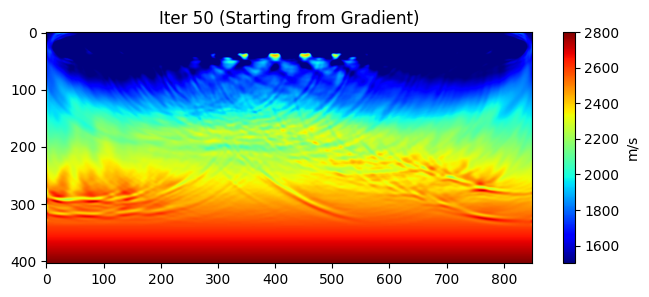

Epoch 060 | Norm Loss: 0.0556 | LR: 30.0000
Epoch 070 | Norm Loss: 0.0507 | LR: 30.0000
Epoch 080 | Norm Loss: 0.0453 | LR: 30.0000
Epoch 090 | Norm Loss: 0.0397 | LR: 30.0000
Epoch 100 | Norm Loss: 0.0354 | LR: 30.0000


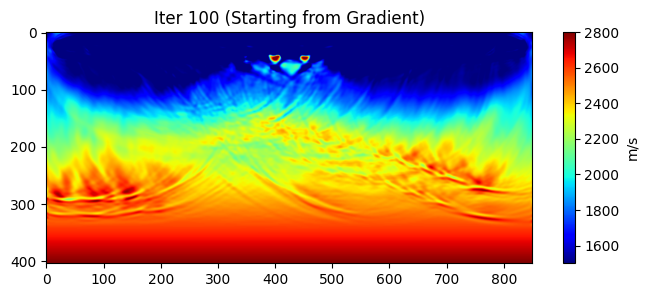

KeyboardInterrupt: 

In [ ]:
import numpy as np
import torch
import scipy.io
import gc
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# 0. INITIAL MEMORY CLEAN
gc.collect()
torch.cuda.empty_cache()

# 1. SETTINGS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 2. INPUT: ANTICLINE MODEL
mat_path = 'anticline_model.mat'
try:
    mat = scipy.io.loadmat(mat_path)
    v_true_np = None
    for key in mat:
        if isinstance(mat[key], np.ndarray):
            arr = np.squeeze(mat[key])
            if arr.ndim == 2:
                v_true_np = arr.astype(np.float32)
                break
    if v_true_np is None: raise ValueError("Invalid 2D array.")
    if np.max(v_true_np) < 10: v_true_np *= 1000.0
except:
    # Fallback if file not found
    v_true_np = 2000 * np.ones((850, 404), dtype=np.float32)
    v_true_np[:, 200:] = 3500

v_true = torch.from_numpy(v_true_np).to(device)
if v_true.shape[0] < v_true.shape[1]: v_true = v_true.T
nx, nz = v_true.shape
vmin, vmax = v_true.min().item(), v_true.max().item()

# 3. INITIAL MODEL: SIMPLE LINEAR GRADIENT (Replaces Smooth Model)
# We create a 1D vertical profile and tile it across all X samples
v_top = vmin
v_bottom = vmax
v_gradient = np.linspace(v_top, v_bottom, nz).astype(np.float32)
v_init_np = np.tile(v_gradient, (nx, 1))

v_init = torch.from_numpy(v_init_np).to(device)
v1 = v_init.clone().requires_grad_(True)

# 4. GEOMETRY (Optimized for T4 15GB RAM)
pml_v = 20
dx, dz = 25.0, 25.0
spacing = (dx, dz)
dt = 0.004  # CFL stable for 25m grid, saves 25% memory
nt = 2000   # 8.0 Seconds
freq = 5.0
n_shots = 16

rx = torch.arange(pml_v, nx - pml_v, device=device)
n_receivers_per_shot = len(rx)

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[..., 1] = pml_v + 2
source_loc[:, 0, 0] = torch.linspace(pml_v, nx - pml_v, n_shots).to(torch.long)

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = pml_v + 2
for i in range(n_shots): receiver_loc[i, :, 0] = rx

source_amp_cpu = deepwave.wavelets.ricker(freq, nt, dt, 1.5/freq).repeat(n_shots, 1, 1)

# 5. GENERATE OBSERVED DATA
print(f"Generating synthetic data from True Model...")
observed_data_cpu = torch.zeros(n_shots, n_receivers_per_shot, nt)

with torch.no_grad():
    for i in range(n_shots):
        s_amp = source_amp_cpu[i:i+1].to(device)
        out = scalar(v_true, spacing, dt, source_amplitudes=s_amp,
                     source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                     pml_width=[pml_v]*4, pml_freq=freq)
        observed_data_cpu[i] = out[-1].cpu()
        del out, s_amp
        torch.cuda.empty_cache()

# Calculate initial loss for normalization
with torch.no_grad():
    initial_loss = 0
    for i in range(n_shots):
        s_amp = source_amp_cpu[i:i+1].to(device)
        out_init = scalar(v1, spacing, dt, source_amplitudes=s_amp,
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)
        initial_loss += torch.nn.MSELoss()(out_init[-1], observed_data_cpu[i:i+1].to(device)).item()
        del out_init, s_amp
    initial_loss /= n_shots

# 6. ILLUMINATION & DEPTH PRECONDITIONING
# Needed to help the anticline "grow" out of the linear gradient
z = torch.linspace(0, 1, nz, device=device)
z_gain = (1.0 + 40.0 * z**3).view(1, nz) # Strong cubic boost for depth

x_gain = torch.ones(nx, device=device) # Edge boost for flank illumination
x_gain[:150] = torch.linspace(2.0, 1.0, 150, device=device)
x_gain[-150:] = torch.linspace(1.0, 2.0, 150, device=device)
full_gain = z_gain * x_gain.view(nx, 1)

# 7. INVERSION
# Starting from a gradient requires a slightly lower LR initially for stability
optimizer = torch.optim.Adam([v1], lr=30.0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
loss_history = []

print("Starting Inversion from Linear Gradient...")
for epoch in range(200):
    optimizer.zero_grad()
    epoch_loss = 0

    for i in range(n_shots):
        curr_source = source_amp_cpu[i:i+1].to(device)
        curr_obs = observed_data_cpu[i:i+1].to(device)

        out_pred = scalar(v1, spacing, dt, source_amplitudes=curr_source,
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)

        loss = torch.nn.MSELoss()(out_pred[-1], curr_obs)
        # Gradient accumulation normalized by number of shots
        (loss / (initial_loss * n_shots)).backward()
        epoch_loss += (loss / initial_loss).item()

        del out_pred, curr_source, curr_obs
        torch.cuda.empty_cache()

    epoch_loss /= n_shots

    # Process Gradient
    with torch.no_grad():
        if v1.grad is not None:
            v1.grad *= full_gain
            # Stricter clipping for the first 50 epochs to stabilize gradient start
            clip_val = 0.5 if epoch < 50 else 0.8
            torch.nn.utils.clip_grad_norm_(v1, max_norm=clip_val)

            # Smooth gradient to prevent high-frequency noise artifacts
            grad = gaussian_filter(v1.grad.cpu().numpy(), sigma=2.5)
            v1.grad.copy_(torch.from_numpy(grad).to(device))

            optimizer.step()
            v1.clamp_(min=vmin, max=vmax)

    scheduler.step(epoch_loss)
    loss_history.append(epoch_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:03d} | Norm Loss: {epoch_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.4f}")

    if (epoch + 1) % 50 == 0:
        plt.figure(figsize=(8,3))
        plt.imshow(v1.detach().cpu().numpy().T, cmap='jet', vmin=vmin, vmax=vmax)
        plt.title(f"Iter {epoch+1} (Starting from Gradient)")
        plt.colorbar(label='m/s')
        plt.show()
        gc.collect(); torch.cuda.empty_cache()

# 8. FINAL PLOTS
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
imgs = [v_init.cpu().numpy(), v1.detach().cpu().numpy(), v_true.cpu().numpy()]
titles = ["Initial Model (Linear Gradient)", "FWI Final Result", "True Model"]
for i in range(3):
    im = ax[i].imshow(imgs[i].T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax, extent=[0, nx*dx, nz*dz, 0])
    ax[i].set_title(titles[i]); fig.colorbar(im, ax=ax[i], label='m/s')
plt.tight_layout(); plt.show()